In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# model testing

model = load_model(f'3d_cnn3.h5', compile=False)
pickle_in_x = open("training_data_subsampled_X.pickle", "rb")
pickle_in_y = open("training_data_subsampled_y.pickle", "rb")
X = pickle.load(pickle_in_x)
y = pickle.load(pickle_in_y)


Metal device set to: Apple M1 Pro


2023-01-30 10:06:12.365336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-30 10:06:12.365919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model

1/1 [==============================] - 0s 42ms/step
(180, 240)


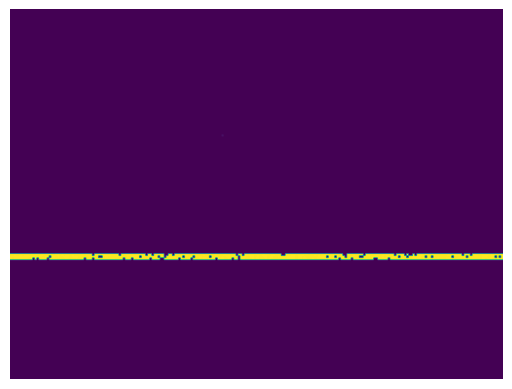

In [8]:
y = model.predict(X[2].reshape(-1, 895, 16, 16, 1)) * 255
img = y.reshape(180, 240)
fig, ax = plt.subplots()
ax.imshow(img)
plt.axis('off')
print(img.shape)